In [2]:
import pandas as pd
import re
from pathlib import Path
from typing import Optional, Tuple
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
def load_and_prepare_data(data_path: Path, text_column: str = 'text', label_column: str = 'PHQ8_Binary') -> Optional[Tuple[pd.Series, pd.Series]]:
    """
    Loads a dataset from a CSV file and prepares it for model training.

    This function reads a CSV file, validates the required columns, and separates
    the features (text) from the labels.

    Args:
        data_path (Path): The full path to the input CSV file.
        text_column (str): The name of the column containing the text data.
        label_column (str): The name of the column containing the labels.

    Returns:
        Optional[Tuple[pd.Series, pd.Series]]: A tuple containing two pandas Series 
                                               (X_data, y_data) if successful. 
                                               Returns None if an error occurs.
    """
    # Validates the file path
    if not data_path.is_file():
        print(f"Error: The file was not found at the specified path: {data_path}")
        return None

    # Loads the dataset
    try:
        df = pd.read_csv(data_path)
    except Exception as e:
        print(f"Error: Failed to read the CSV file. Details: {e}")
        return None

    # Validates required columns
    if text_column not in df.columns or label_column not in df.columns:
        print(f"Error: The required columns ('{text_column}', '{label_column}') were not found.")
        return None

    # Separates features and labels
    X_data = df[text_column]
    y_data = df[label_column]

    print(f"Data loaded successfully. Found {len(df)} records.")
    
    return X_data, y_data

In [11]:
if __name__ == '__main__':
    # Loading the training dataset as pandas series
    training_data_path = Path('data/final_training_dataset.csv')
    
    # Calls the function
    result = load_and_prepare_data(training_data_path)
    
    if result:
        X_train, y_train = result
        print("\nSample of training features (X_train):")
        print(X_train.head())
        print("\nSample of training labels (y_train):")
        print(y_train.head())

Data loaded successfully. Found 107 records.

Sample of training features (X_train):
0    okay how 'bout yourself here in california yea...
1    i'm doing good um from los angeles california ...
2    i'm doing alright uh originally i'm from calif...
3    yes it's okay <laughter> fine <laughter> i liv...
4    yes fine how about you here yes the weather we...
Name: text, dtype: object

Sample of training labels (y_train):
0    0
1    0
2    0
3    0
4    0
Name: PHQ8_Binary, dtype: int64


In [12]:
# Loading the validation dataset as pandas series
validation_data_path = Path('data/final_dev_dataset.csv')
    
# Calls the function
result = load_and_prepare_data(validation_data_path)
    
if result:
    X_val, y_val = result
    print("\nSample of val features (X_train):")
    print(X_val.head())
    print("\nSample of val labels (y_train):")
    print(y_val.head())

Data loaded successfully. Found 35 records.

Sample of val features (X_train):
0    i'm fine how about yourself  i'm from los ange...
1    <laughter> um moscow um my family moved to the...
2    yes  okay  connecticut um  to be an actor <lau...
3    yes i'm okay  uh i'm from here originally los ...
4    yes  i'm okay  here in los angeles  there's a ...
Name: text, dtype: object

Sample of val labels (y_train):
0    0
1    0
2    0
3    1
4    1
Name: PHQ8_Binary, dtype: int64


In [13]:
def clean_text(X: pd.Series) -> pd.Series:
    """
    Performs basic preprocessing on a pandas Series of text.
    - Converts text to lowercase.
    - Removes special characters.
    - Removes extra whitespace.
    
    Args:
        X (pd.Series): The raw text Series to preprocess.
    
    Returns:
        pd.Series: The processed text Series.
    """
    # Ensures all data is treated as a string, then convert to lowercase
    processed_series = X.astype(str).str.lower()
    
    # Replaces any character that is not a letter, number, or whitespace with a space
    processed_series = processed_series.str.replace(r'[^a-zA-Z0-9\s]', ' ', regex=True)
    
    # Replaces multiple whitespace characters with a single space and strip leading/trailing spaces
    processed_series = processed_series.str.replace(r'\s+', ' ', regex=True).str.strip()
    
    return processed_series


In [41]:
X_train_cleaned = clean_text(X_train)
print(X_train_cleaned.head)
print(f"type of X_train_cleaned: {type(X_train_cleaned)}")

<bound method NDFrame.head of 0      okay how bout yourself here in california yeah...
1      i m doing good um from los angeles california ...
2      i m doing alright uh originally i m from calif...
3      yes it s okay laughter fine laughter i live in...
4      yes fine how about you here yes the weather we...
                             ...                        
102    synch yes i m not bad i m a little tired but o...
103    synch yes i m feel great i am from saint louis...
104    synch yes i m fine thank you detroit michigan ...
105    synch yes fine oh san fernando valley uh well ...
106    synch yes huh overwhelmed i have a funeral to ...
Name: text, Length: 107, dtype: object>
type of X_train_cleaned: <class 'pandas.core.series.Series'>


# 4. Preprocessing for DistilBERT: Tokenization
The next step is to prepare our text data for the DistilBERT model. Unlike our baseline model, transformers require a specific tokenization process. We will use the pre-trained `DistilBertTokenizer` to convert our text into numerical inputs that the model expects.

First, let's load the tokenizer and test it on a few sample sentences from our training data to understand its output.

In [15]:
print(X_train.shape)

(107,)


In [16]:
print(X_train_cleaned.shape)

(107,)


In [3]:
from transformers import DistilBertTokenizer
import tensorflow as tf

/Users/ujjwalpoudel/Documents/insane_projects/Conversational-Health-Analytics-/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

In [22]:
sample_texts = X_train_cleaned.head(3).tolist()
print("\nSample Texts")
for i, text in enumerate(sample_texts):
    # Prints a snippet of the text
    print(f"{i+1}: {text[:100]}...")


Sample Texts
1: okay how bout yourself here in california yeah oh well that it s big and broad there s a lot to do a...
2: i m doing good um from los angeles california um the cool weather the beaches the people the schools...
3: i m doing alright uh originally i m from california uh born in glendale i m not too happy with it uh...


In [23]:
tokenized_output = tokenizer(
    sample_texts, 
    padding=True, 
    truncation=True,
    max_length=512, # Explicitly setting a max length
    return_tensors='tf'
)

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.


In [24]:
# Inspecting the tokenizer
print("\nTokenizer Output")
for key, value in tokenized_output.items():
    print(f"\n{key}:")
    print(value.numpy())


Tokenizer Output

input_ids:
[[ 101 3100 2129 ... 2128 1996  102]
 [ 101 1045 1049 ... 2123 1056  102]
 [ 101 1045 1049 ... 3470 2008  102]]

attention_mask:
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]


Token indices sequence length is longer than the specified maximum sequence length for this model (2093 > 512). Running this sequence through the model will result in indexing errors


--- Token Length Analysis ---
count     107.000000
mean     1485.598131
std       835.808397
min       187.000000
25%       852.000000
50%      1296.000000
75%      1854.500000
max      4352.000000
dtype: float64

Number of interviews with more than 512 tokens: 103 (96.26%)


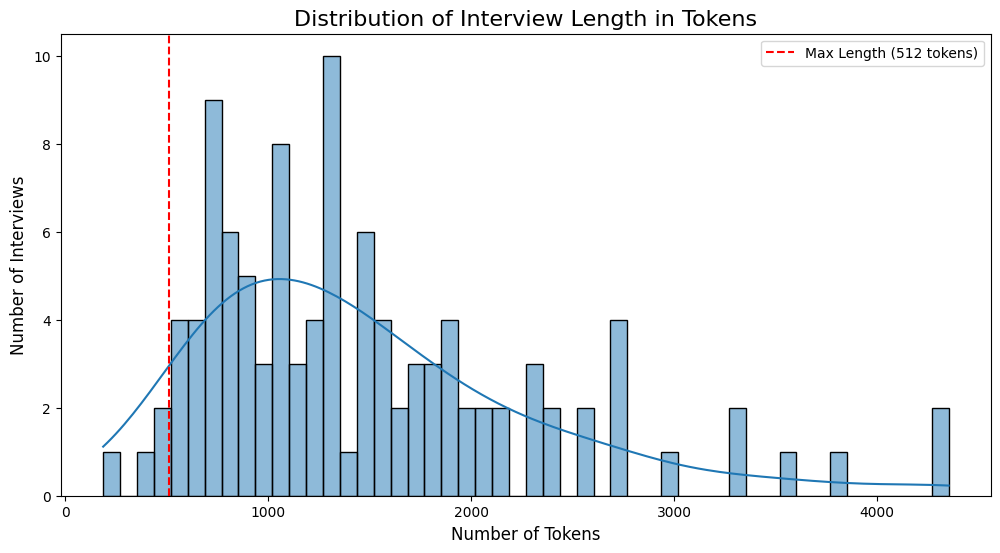

In [30]:
def analyze_token_length_from_series(text_series: pd.Series):
    """
    Analyzes and plots the distribution of token lengths from a pandas Series.

    Args:
        text_series (pd.Series): The input pandas Series containing text documents.
    """
    # Load the tokenizer
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

    # Calculate the number of tokens for each document in the Series
    token_lengths = [len(tokenizer.encode(str(text))) for text in text_series]

    # Convert to a pandas Series for easy analysis
    token_lengths_series = pd.Series(token_lengths)

    # --- Analysis ---
    print("--- Token Length Analysis ---")
    print(token_lengths_series.describe())

    # Find how many are over the 512 token limit
    num_long_texts = (token_lengths_series > 512).sum()
    percentage = (num_long_texts / len(token_lengths_series)) * 100

    print(f"\nNumber of interviews with more than 512 tokens: {num_long_texts} ({percentage:.2f}%)")

    # --- Visualization ---
    plt.figure(figsize=(12, 6))
    sns.histplot(token_lengths_series, bins=50, kde=True)
    plt.title('Distribution of Interview Length in Tokens', fontsize=16)
    plt.xlabel('Number of Tokens', fontsize=12)
    plt.ylabel('Number of Interviews', fontsize=12)
    # Add a vertical line at the 512 token limit for reference
    plt.axvline(x=512, color='red', linestyle='--', label='Max Length (512 tokens)')
    plt.legend()
    plt.show()


analyze_token_length_from_series(X_train_cleaned)

In [31]:
type(X_train_cleaned)

pandas.core.series.Series

In [4]:
from transformers import DistilBertTokenizer, TFDistilBertModel
from typing import List, Tuple

In [5]:
def create_text_chunks(text: str, tokenizer: DistilBertTokenizer, 
    chunk_size: int = 512, 
    overlap: int = 50) -> List[str]:
    """
    Splits a long text into smaller, overlapping chunks based on tokens.

    Args:
        text (str): The long text document to be chunked.
        tokenizer (DistilBertTokenizer): The tokenizer to use for splitting the text.
        chunk_size (int): The target size of each chunk in tokens.
        overlap (int): The number of tokens to overlap between chunks.

    Returns:
        List[str]: A list of text strings, where each string is a chunk.
    """
    # Tokenize the entire text to get a list of token IDs
    tokens = tokenizer.encode(text, add_special_tokens=False)
    
    # If the text is short enough, no chunking is needed
    if len(tokens) <= chunk_size:
        return [text]

    # Calculate the step size for sliding the window
    step_size = chunk_size - overlap
    
    chunks = []
    # Slide a window over the list of tokens
    for i in range(0, len(tokens) - overlap, step_size):
        chunk_tokens = tokens[i:i + chunk_size]
        # Convert the token chunk back into a string for the tokenizer to process later
        chunk_text = tokenizer.decode(chunk_tokens)
        chunks.append(chunk_text)
        
    return chunks

In [6]:
def create_chunk_dataset(
    df: pd.DataFrame, 
    tokenizer: DistilBertTokenizer
) -> pd.DataFrame:
    """
    Creates a new DataFrame where each row is a text chunk, associated with
    the original document's label.

    Args:
        df (pd.DataFrame): DataFrame with 'text' and 'PHQ8_Binary' columns.
        tokenizer (DistilBertTokenizer): The tokenizer for chunking.

    Returns:
        pd.DataFrame: A new DataFrame with 'chunk_text' and 'label' columns.
    """
    new_rows = []
    # Iterate through each original document (each row in the input df)
    for index, row in df.iterrows():
        original_text = row['text']
        original_label = row['PHQ8_Binary']
        
        # Create chunks from the original text
        text_chunks = create_text_chunks(original_text, tokenizer)
        
        # For each chunk, create a new row with the chunk text and the original label
        for chunk in text_chunks:
            new_rows.append({'chunk_text': chunk, 'label': original_label})
            
    return pd.DataFrame(new_rows)

In [7]:
def tokenize_and_create_tf_dataset(
    df: pd.DataFrame, 
    tokenizer: DistilBertTokenizer, 
    max_length: int = 512, 
    batch_size: int = 16
) -> tf.data.Dataset:
    """
    Tokenizes a DataFrame of text chunks and converts it into a TensorFlow Dataset.

    Args:
        df (pd.DataFrame): DataFrame with 'chunk_text' and 'label' columns.
        tokenizer (DistilBertTokenizer): The tokenizer to use.
        max_length (int): The maximum token length for padding/truncation.
        batch_size (int): The batch size for the TensorFlow dataset.

    Returns:
        tf.data.Dataset: A batched dataset ready for model training.
    """
    # Tokenize all the text chunks at once
    tokenized_output = tokenizer(
        df['chunk_text'].tolist(),
        padding=True,
        truncation=True,
        max_length=max_length,
        return_tensors='tf'
    )
    
    labels = df['label'].values
    
    # Create the TensorFlow dataset
    dataset = tf.data.Dataset.from_tensor_slices(
        (dict(tokenized_output), labels)
    )
    
    # Shuffle and batch the dataset
    dataset = dataset.shuffle(len(df)).batch(batch_size)
    
    return dataset

In [9]:
def build_distilbert_classifier(max_length: int = 512):
    """
    Builds a Keras model with a pre-trained DistilBERT base and a classification head.

    Args:
        max_length (int): The maximum sequence length the model expects.

    Returns:
        tf.keras.Model: The compiled Keras model.
    """
    # Defines the input layers
    input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='input_ids')
    attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='attention_mask')
    
    # Load the pre-trained DistilBERT model
    distilbert_base = TFDistilBertModel.from_pretrained('distilbert-base-uncased')
    distilbert_base.trainable = True  # We want to fine-tune the model
    
    # Get the model's output
    transformer_output = distilbert_base(input_ids, attention_mask=attention_mask)[0]
    
    # The [CLS] token output is a good representation of the entire sequence
    cls_token_output = transformer_output[:, 0, :]
    
    # Add a classification head
    x = tf.keras.layers.Dropout(0.2)(cls_token_output)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    
    # Create the final model
    model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)
    
    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=['accuracy']
    )
    
    return model

In [10]:
def clean_text(text: str) -> str:
    """
    Performs gentle text cleaning for NLP models.
    - Converts text to lowercase.
    - Removes special characters, replacing them with a space.
    - Removes extra whitespace.

    Args:
        text (str): The input text string.

    Returns:
        str: The cleaned text string.
    """
    text = str(text).lower()  # Convert to lowercase
    # Replace any character that is not a letter, number, or whitespace with a space
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
    # Replace multiple whitespace characters with a single space
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [11]:
def load_and_clean_dataset(data_path: Path) -> Optional[pd.DataFrame]:
    """
    Loads a dataset from a CSV file and applies basic text cleaning.

    Args:
        data_path (Path): The full path to the input CSV file.

    Returns:
        Optional[pd.DataFrame]: The loaded and cleaned DataFrame, or None if an error occurs.
    """
    if not data_path.is_file():
        print(f"Error: The file was not found at the specified path: {data_path}")
        return None

    try:
        df = pd.read_csv(data_path)
        print(f"Successfully loaded {len(df)} records from {data_path.name}.")
        
        # --- Apply the cleaning function ---
        print("Applying text cleaning...")
        df['cleaned_text'] = df['text'].apply(clean_text)
        print("Text cleaning complete.")
        
        return df
        
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

In [12]:
if __name__ == '__main__':
    training_data_path = Path('/Volumes/MACBACKUP/final_training_dataset.csv')
    full_train_df = load_and_clean_dataset(training_data_path)
    sample_df = full_train_df.sample(5)

    print("--- 1. Starting with 5 sample documents ---")
    print(full_train_df)

    # Preprocessing
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

    print("\n--- 2. Creating chunk-based dataset ---")
    chunk_df = create_chunk_dataset(sample_df, tokenizer)
    print(f"Created {len(chunk_df)} chunks from {len(sample_df)} documents.")
    print(chunk_df.head())

    print("\n--- 3. Tokenizing and creating TensorFlow dataset ---")
    train_dataset = tokenize_and_create_tf_dataset(chunk_df, tokenizer)
    print("TensorFlow dataset created successfully.")

    # --- Model Training ---
    print("\n--- 4. Building the model ---")
    model = build_distilbert_classifier()
    model.summary()

    print("\n--- 5. Starting model training (on the 5-document sample) ---")
    # For a real run, you would also pass a validation_data argument
    history = model.fit(
        train_dataset,
        epochs=1 
    )
    print("\nSample training complete.")

/Users/ujjwalpoudel/Documents/insane_projects/Conversational-Health-Analytics-/venv/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for this model (639 > 512). Running this sequence through the model will result in indexing errors


Successfully loaded 107 records from final_training_dataset.csv.
Applying text cleaning...
Text cleaning complete.
--- 1. Starting with 5 sample documents ---
     participant_id                                               text  \
0               303  okay how 'bout yourself here in california yea...   
1               304  i'm doing good um from los angeles california ...   
2               305  i'm doing alright uh originally i'm from calif...   
3               310  yes it's okay <laughter> fine <laughter> i liv...   
4               312  yes fine how about you here yes the weather we...   
..              ...                                                ...   
102             485  <synch> yes i'm not bad i'm a little tired but...   
103             486  <synch> yes i'm feel great i am from saint lou...   
104             487  <synch> yes i'm fine thank you detroit michiga...   
105             488  <synch> yes fine oh san fernando valley uh wel...   
106             491  <synch

2025-10-08 03:23:21.823510: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-10-08 03:23:21.823549: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-10-08 03:23:21.823567: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-10-08 03:23:21.823759: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-10-08 03:23:21.824041: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


RecursionError: maximum recursion depth exceeded while calling a Python object